<img src="https://upload.wikimedia.org/wikipedia/fr/8/81/Sciences_SU.png" width="240" height="240" align="center"/>


# MLA 703. RNN-LSTM et architectures avancées [Analyse de sentiment]

In [1]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# 1. Importation des modules

In [2]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Charger les données

## 2. Formater/Préparer les données

In [3]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, maxlen=max_len)
                                            

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print("x_train lenght:", len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
x_train lenght: 2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

In [5]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D 
from tensorflow.keras.regularizers import l2
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model1 = Sequential()
model1.add(Embedding(num_words, embed_size))                 # layer embedding
model1.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model1.add(Dropout(0.25))                                    # layer Dropout
model1.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model1.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [6]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history1 = model1.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 2s 23ms/step - loss: 2.1919 - accuracy: 0.4874 - val_loss: 0.8402 - val_accuracy: 0.5423
Epoch 2/10
35/35 [==============================] - 1s 17ms/step - loss: 1.0075 - accuracy: 0.6758 - val_loss: 1.9995 - val_accuracy: 0.4595
Epoch 3/10
35/35 [==============================] - 1s 18ms/step - loss: 0.9241 - accuracy: 0.7705 - val_loss: 1.4761 - val_accuracy: 0.5568
Epoch 4/10
35/35 [==============================] - 1s 17ms/step - loss: 0.2401 - accuracy: 0.9387 - val_loss: 1.8376 - val_accuracy: 0.5279
Epoch 5/10
35/35 [==============================] - 1s 17ms/step - loss: 0.1348 - accuracy: 0.9752 - val_loss: 2.1944 - val_accuracy: 0.5369
Epoch 6/10
35/35 [==============================] - 1s 17ms/step - loss: 0.1172 - accuracy: 0.9811 - val_loss: 1.8309 - val_accuracy: 0.5622
Epoch 7/10
35/35 [==============================] - 1s 17ms/step - loss: 0.1156 - accuracy: 0.9838 - val_loss: 2.5079 - val_accuracy: 0.5568
Epoch 8/10
35

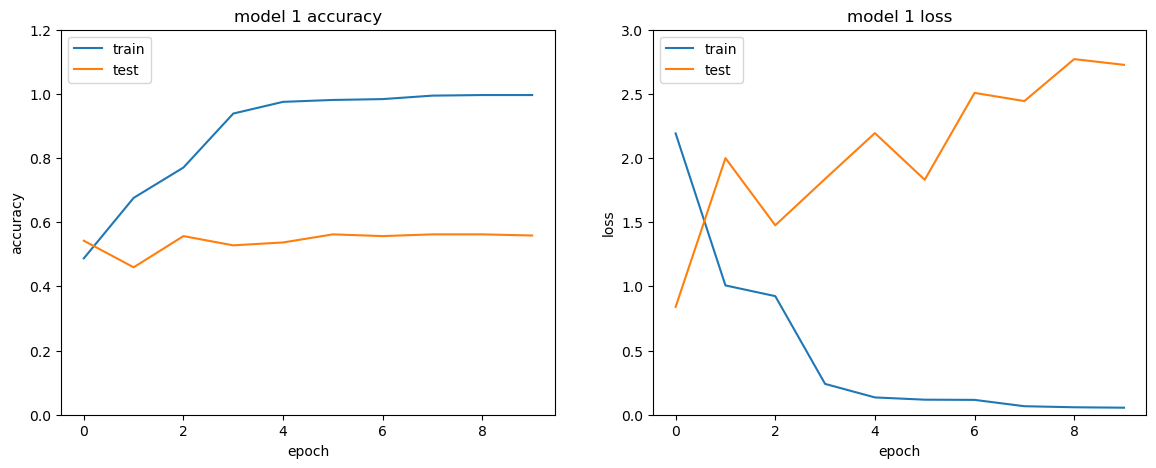

In [7]:
def plot_history(history, mod_name):
    plt.figure(figsize=[14,5])

    # On trace la loss et l'accuracy du modèle
    # On trace l'évolution de l'accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy']) 
    plt.title(mod_name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim([0,1.2])
    plt.legend(['train', 'test'], loc='upper left')

    # On trace l'évolution de la loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(mod_name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim([0,3])
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history1, "model 1")

In [8]:
def pred(modelx, x_test) :
    # On prédit sur les données de test
    y_hat = modelx.predict(x_test)

    # On tranforme les prédictions en labels
    i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
    i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

    y_pred   = np.zeros(len(y_hat))
    y_pred[i_pos] = 1
    y_pred[i_neg] = 0

    return y_pred

y_pred1 = pred(model1, x_test)

93/93 [==============================] - 1s 4ms/step


In [9]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test_1 = confusion_matrix(y_test, y_pred1)
print('La matrice de confusion sur le jeu de test :\n', cm_test_1, '\n')

# On calcul le score d accuracy
acc_test_1 = accuracy_score(y_test, y_pred1)
print("L'accuracy sur le jeu de test est :\n", acc_test_1)


La matrice de confusion sur le jeu de test :
 [[ 238 1121]
 [ 187 1417]] 

L'accuracy sur le jeu de test est :
 0.5585555180560243


# RNN-LSTM gauche-droite classique


In [10]:
# on definie model2 : RNN-LSTM gauche-droite classique 
model2 = Sequential()

model2.add(Embedding(num_words, embed_size))    
model2.add(LSTM(units=64))
model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))

# On affiche l'architecture de notre modèle
model2.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [11]:
history2 = model2.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 3s 57ms/step - loss: 0.6768 - accuracy: 0.5618 - val_loss: 0.6240 - val_accuracy: 0.6577
Epoch 2/10
35/35 [==============================] - 2s 55ms/step - loss: 0.4697 - accuracy: 0.8039 - val_loss: 0.4298 - val_accuracy: 0.7964
Epoch 3/10
35/35 [==============================] - 2s 53ms/step - loss: 0.2498 - accuracy: 0.9157 - val_loss: 0.4485 - val_accuracy: 0.7982
Epoch 4/10
35/35 [==============================] - 2s 54ms/step - loss: 0.1395 - accuracy: 0.9572 - val_loss: 0.4996 - val_accuracy: 0.8072
Epoch 5/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0873 - accuracy: 0.9761 - val_loss: 0.4734 - val_accuracy: 0.8180
Epoch 6/10
35/35 [==============================] - 2s 49ms/step - loss: 0.0479 - accuracy: 0.9896 - val_loss: 0.5356 - val_accuracy: 0.8198
Epoch 7/10
35/35 [==============================] - 2s 53ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.5253 - val_accuracy: 0.8090
Epoch 8/10
35

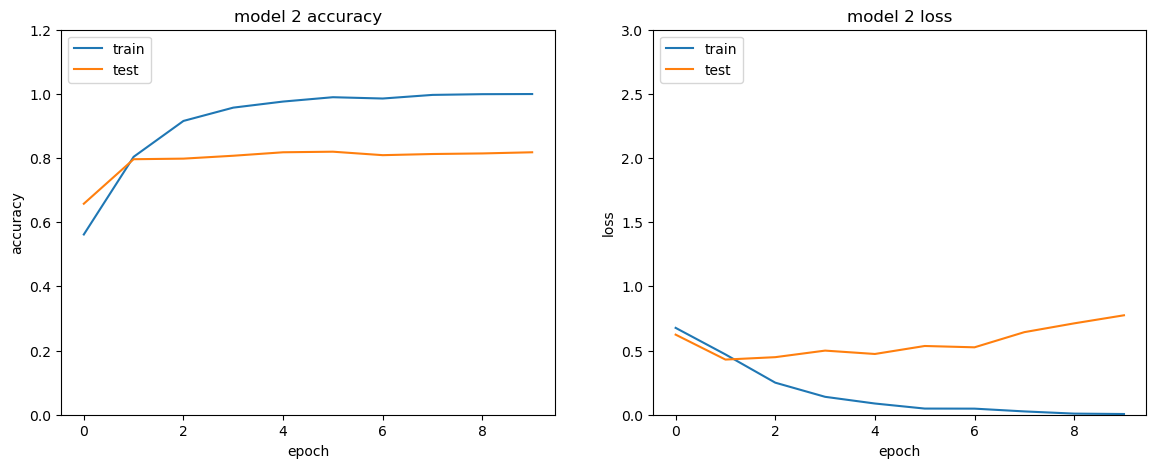

In [12]:
plot_history(history2, "model 2")

In [13]:
y_pred2 = pred(model2, x_test)

# On calcule la matrice de confusion
cm_test_2 = confusion_matrix(y_test, y_pred2)
print('La matrice de confusion sur le jeu de test :\n', cm_test_2, '\n')

# On calcul le score d accuracy
acc_test_2 = accuracy_score(y_test, y_pred2)
print("L'accuracy sur le jeu de test est :\n", acc_test_2)

93/93 [==============================] - 1s 11ms/step
La matrice de confusion sur le jeu de test :
 [[   0 1359]
 [   0 1604]] 

L'accuracy sur le jeu de test est :
 0.5413432332095849


# LSTM bi-directionnel avec return_sequences = False


In [14]:
# Modèle 3 : LSTM bi-directionnel et return_sequences=False
model3 = Sequential()
model3.add(Embedding(num_words, embed_size))    
model3.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model3.add(Dropout(0.25))
model3.add(Dense(1, activation='sigmoid'))

# On affiche l'architecture de notre modèle
model3.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [15]:
history3 = model3.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 6s 115ms/step - loss: 0.6781 - accuracy: 0.5496 - val_loss: 0.5755 - val_accuracy: 0.6649
Epoch 2/10
35/35 [==============================] - 3s 100ms/step - loss: 0.4859 - accuracy: 0.8138 - val_loss: 0.4853 - val_accuracy: 0.7802
Epoch 3/10
35/35 [==============================] - 3s 100ms/step - loss: 0.2809 - accuracy: 0.8963 - val_loss: 0.4730 - val_accuracy: 0.8216
Epoch 4/10
35/35 [==============================] - 4s 101ms/step - loss: 0.1534 - accuracy: 0.9500 - val_loss: 0.3542 - val_accuracy: 0.8432
Epoch 5/10
35/35 [==============================] - 3s 95ms/step - loss: 0.0885 - accuracy: 0.9770 - val_loss: 0.3690 - val_accuracy: 0.8396
Epoch 6/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0475 - accuracy: 0.9883 - val_loss: 0.7048 - val_accuracy: 0.8072
Epoch 7/10
35/35 [==============================] - 3s 95ms/step - loss: 0.0356 - accuracy: 0.9937 - val_loss: 0.4340 - val_accuracy: 0.8468
Epoch 8/1

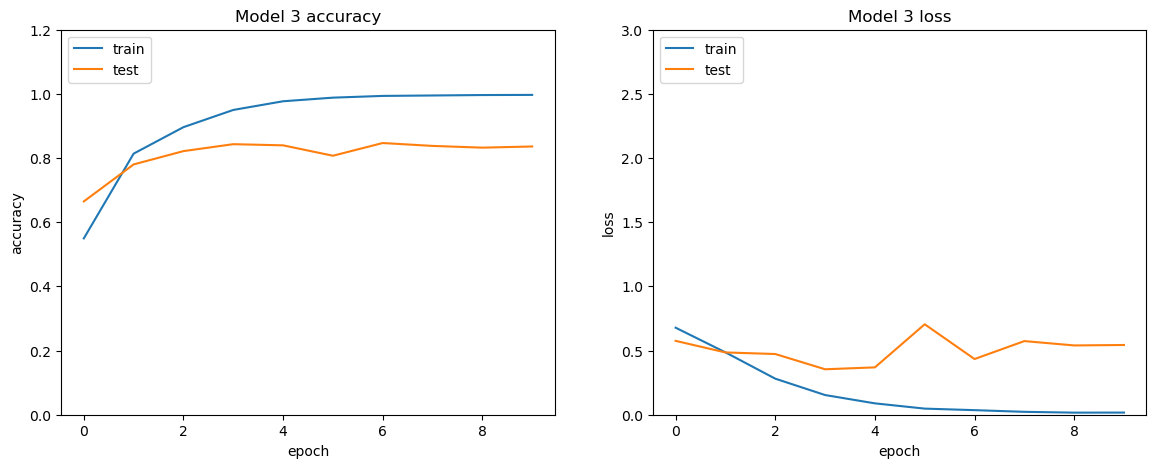

In [16]:
plot_history(history3, "Model 3")

In [17]:
y_pred3 = pred(model3, x_test)

# On calcule la matrice de confusion
cm_test_3 = confusion_matrix(y_test, y_pred3)
print('La matrice de confusion sur le jeu de test :\n', cm_test_3, '\n')

# On calcul le score d accuracy
acc_test_3 = accuracy_score(y_test, y_pred3)
print("L'accuracy sur le jeu de test est :\n", acc_test_3)

93/93 [==============================] - 2s 15ms/step
La matrice de confusion sur le jeu de test :
 [[   0 1359]
 [   0 1604]] 

L'accuracy sur le jeu de test est :
 0.5413432332095849


# LSTM bi-directionnel + LSTM classique


In [18]:
# Modèle 4 : LSTM bi-directionnel et return_sequences=False
model4 = Sequential()
model4.add(Embedding(num_words, embed_size)) 

model4.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model4.add(Dropout(0.4))

model4.add(LSTM(units=32))
model4.add(Dropout(0.25))

model4.add(Dense(1, activation='tanh', kernel_regularizer=l2(0.01)))

# On affiche l'architecture de notre modèle
model4.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                      

In [19]:
history4 = model4.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 8s 149ms/step - loss: 0.9602 - accuracy: 0.5464 - val_loss: 0.6721 - val_accuracy: 0.6649
Epoch 2/10
35/35 [==============================] - 5s 144ms/step - loss: 0.5870 - accuracy: 0.7448 - val_loss: 0.5819 - val_accuracy: 0.7351
Epoch 3/10
35/35 [==============================] - 5s 147ms/step - loss: 0.3833 - accuracy: 0.8990 - val_loss: 0.6462 - val_accuracy: 0.8108
Epoch 4/10
35/35 [==============================] - 5s 157ms/step - loss: 0.1893 - accuracy: 0.9653 - val_loss: 0.7507 - val_accuracy: 0.8054
Epoch 5/10
35/35 [==============================] - 6s 158ms/step - loss: 0.1591 - accuracy: 0.9689 - val_loss: 0.6898 - val_accuracy: 0.7604
Epoch 6/10
35/35 [==============================] - 6s 180ms/step - loss: 0.1380 - accuracy: 0.9734 - val_loss: 1.1847 - val_accuracy: 0.8108
Epoch 7/10
35/35 [==============================] - 5s 154ms/step - loss: 0.0864 - accuracy: 0.9896 - val_loss: 1.1589 - val_accuracy: 0.8072
Epoch 

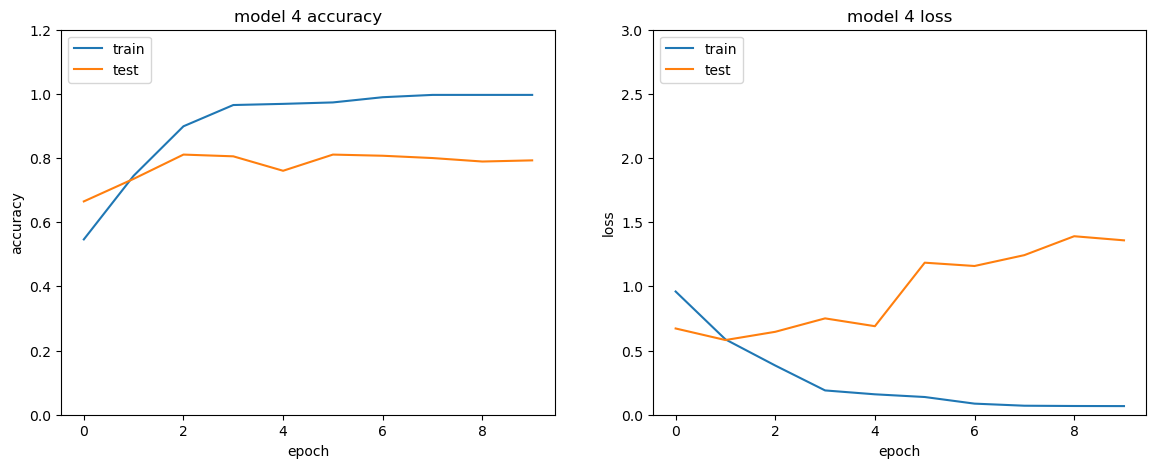

In [20]:
plot_history(history4, 'model 4')

In [21]:
y_pred = pred(model4, x_test)

# On calcule la matrice de confusion
cm_test_4 = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test_4, '\n')

# On calcul le score d accuracy
acc_test_4 = accuracy_score(y_test, y_pred)
print("L'accuracy sur le jeu de test est :\n", acc_test_4)

93/93 [==============================] - 3s 24ms/step
La matrice de confusion sur le jeu de test :
 [[ 844  515]
 [ 154 1450]] 

L'accuracy sur le jeu de test est :
 0.7742153223084711


# Modèle 5 : Chaîne plus longue des LSTMs 

In [22]:
model5 = Sequential()
model5.add(Embedding(num_words, embed_size)) 

model5.add(LSTM(units=128, return_sequences=True))
model5.add(LSTM(units=64, return_sequences=True))
model5.add(LeakyReLU())

model5.add(Dropout(0.2))

model5.add(LSTM(units=32, return_sequences=True))
model5.add(LSTM(units=16, return_sequences=True))
model5.add(LeakyReLU())

model5.add(Dropout(0.2))

model5.add(LSTM(units=8, return_sequences=False))
model4.add(LeakyReLU())

model5.add(Dropout(0.2))

model5.add(Dense(1, activation='tanh', kernel_regularizer=l2(0.01)))

# On affiche l'architecture de notre modèle
model5.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_5 (LSTM)               (None, None, 64)          49408     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_6 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_7 (LSTM)               (None, None, 16)         

In [23]:
history5 = model5.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 21s 360ms/step - loss: 3.0608 - accuracy: 0.4491 - val_loss: 1.0642 - val_accuracy: 0.4324
Epoch 2/10
35/35 [==============================] - 12s 347ms/step - loss: 1.1035 - accuracy: 0.5221 - val_loss: 0.7161 - val_accuracy: 0.5676
Epoch 3/10
35/35 [==============================] - 12s 353ms/step - loss: 0.8104 - accuracy: 0.5482 - val_loss: 0.7054 - val_accuracy: 0.5676
Epoch 4/10
35/35 [==============================] - 12s 340ms/step - loss: 0.7793 - accuracy: 0.5041 - val_loss: 0.7023 - val_accuracy: 0.5676
Epoch 5/10
35/35 [==============================] - 11s 311ms/step - loss: 0.7334 - accuracy: 0.5275 - val_loss: 0.6624 - val_accuracy: 0.6595
Epoch 6/10
35/35 [==============================] - 11s 309ms/step - loss: 0.6086 - accuracy: 0.7164 - val_loss: 0.5771 - val_accuracy: 0.7405
Epoch 7/10
35/35 [==============================] - 11s 311ms/step - loss: 0.6948 - accuracy: 0.6655 - val_loss: 0.5870 - val_accuracy: 0.7279

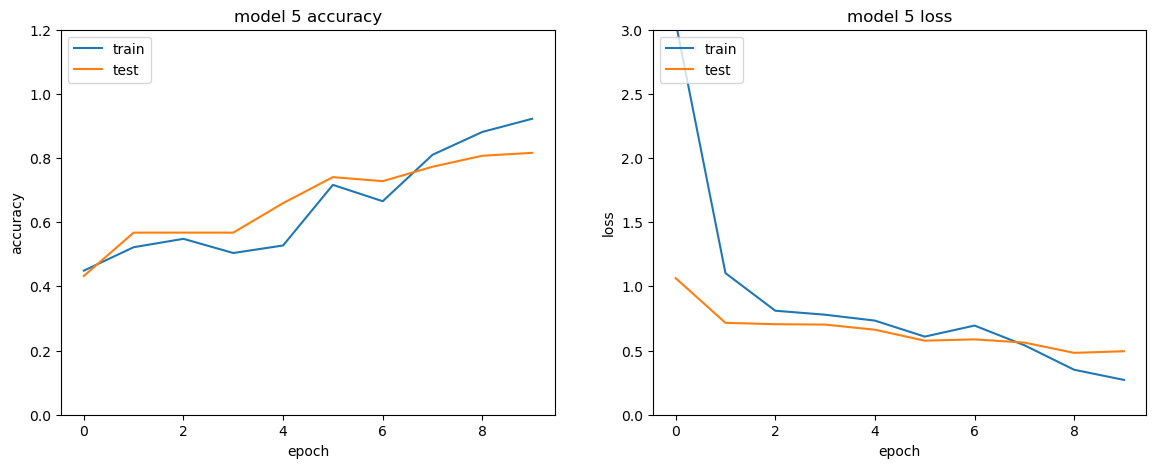

In [24]:
plot_history(history5, "model 5")

In [25]:
y_pred = pred(model5, x_test)

# On calcule la matrice de confusion
cm_test_5 = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test_5, '\n')

# On calcul le score d accuracy
acc_test_5 = accuracy_score(y_test, y_pred)
print("L'accuracy sur le jeu de test est :\n", acc_test_5)

93/93 [==============================] - 6s 55ms/step
La matrice de confusion sur le jeu de test :
 [[ 483  876]
 [  23 1581]] 

L'accuracy sur le jeu de test est :
 0.6965912926088423


## LSTM bidirectionnelle + GlobalMaxPool1D + Dense

In [26]:

model6 = Sequential()
model6.add(Embedding(num_words, embed_size))
model6.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model6.add(GlobalMaxPool1D())

model6.add(Dense(1, activation='tanh'))

# On affiche l'architecture de notre modèle
model6.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [27]:
history6 = model6.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 7s 137ms/step - loss: 0.9734 - accuracy: 0.4955 - val_loss: 0.6829 - val_accuracy: 0.5820
Epoch 2/10
35/35 [==============================] - 4s 118ms/step - loss: 0.6620 - accuracy: 0.6055 - val_loss: 0.6606 - val_accuracy: 0.6342
Epoch 3/10
35/35 [==============================] - 4s 114ms/step - loss: 0.6182 - accuracy: 0.6821 - val_loss: 0.6218 - val_accuracy: 0.7748
Epoch 4/10
35/35 [==============================] - 4s 117ms/step - loss: 0.4708 - accuracy: 0.8508 - val_loss: 0.4456 - val_accuracy: 0.7532
Epoch 5/10
35/35 [==============================] - 4s 120ms/step - loss: 0.2824 - accuracy: 0.8886 - val_loss: 0.4341 - val_accuracy: 0.8252
Epoch 6/10
35/35 [==============================] - 4s 129ms/step - loss: 0.2051 - accuracy: 0.9125 - val_loss: 0.4371 - val_accuracy: 0.7910
Epoch 7/10
35/35 [==============================] - 4s 126ms/step - loss: 0.1798 - accuracy: 0.9409 - val_loss: 0.4363 - val_accuracy: 0.8396
Epoch 

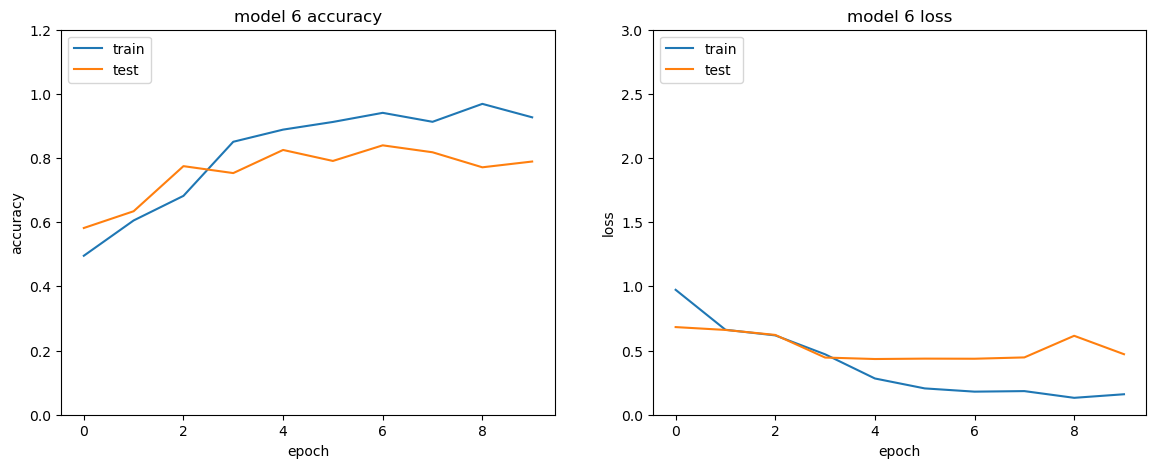

In [28]:
plot_history(history6, "model 6")

In [29]:
y_pred = pred(model6, x_test)

# On calcule la matrice de confusion
cm_test_6 = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test_6, '\n')

# On calcul le score d accuracy
acc_test_6 = accuracy_score(y_test, y_pred)
print("L'accuracy sur le jeu de test est :\n", acc_test_6)

93/93 [==============================] - 2s 16ms/step
La matrice de confusion sur le jeu de test :
 [[ 612  747]
 [  32 1572]] 

L'accuracy sur le jeu de test est :
 0.7370907863651704


# LSTM bidirectionnelle + GlobalMaxPool1D + 2 couches denses

In [30]:
model7 = Sequential()
model7.add(Embedding(num_words, embed_size))
model7.add(Bidirectional(LSTM(64,return_sequences=True)))
model7.add(GlobalMaxPool1D())

model7.add(Dense(32,activation = 'relu'))
model7.add(Dropout(0.2))
model7.add(Dense(1, activation='tanh'))

model7.summary()

model7.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [31]:
history7 = model7.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 7s 125ms/step - loss: 1.2041 - accuracy: 0.4937 - val_loss: 0.6778 - val_accuracy: 0.5802
Epoch 2/10
35/35 [==============================] - 4s 109ms/step - loss: 0.6864 - accuracy: 0.5577 - val_loss: 0.6546 - val_accuracy: 0.6144
Epoch 3/10
35/35 [==============================] - 4s 109ms/step - loss: 0.5909 - accuracy: 0.6898 - val_loss: 0.4524 - val_accuracy: 0.8288
Epoch 4/10
35/35 [==============================] - 4s 109ms/step - loss: 0.3498 - accuracy: 0.8598 - val_loss: 0.4286 - val_accuracy: 0.8450
Epoch 5/10
35/35 [==============================] - 4s 108ms/step - loss: 0.1739 - accuracy: 0.9486 - val_loss: 0.4068 - val_accuracy: 0.8468
Epoch 6/10
35/35 [==============================] - 4s 109ms/step - loss: 0.0750 - accuracy: 0.9824 - val_loss: 0.8502 - val_accuracy: 0.8360
Epoch 7/10
35/35 [==============================] - 4s 108ms/step - loss: 0.0436 - accuracy: 0.9946 - val_loss: 0.8138 - val_accuracy: 0.8234
Epoch 

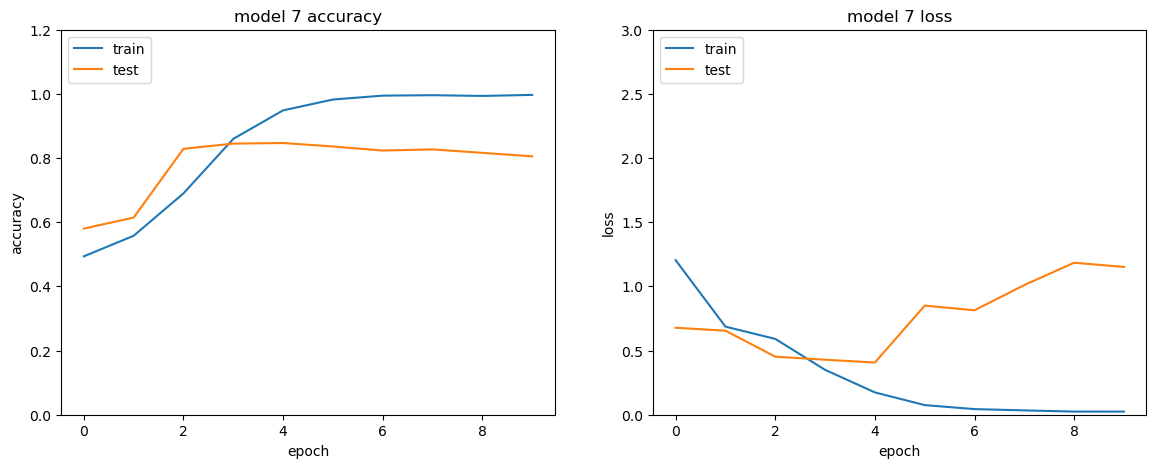

In [32]:
plot_history(history7, "model 7")

In [33]:
y_pred7 = pred(model7, x_test)

# On calcule la matrice de confusion
cm_test_7 = confusion_matrix(y_test, y_pred7)
print('La matrice de confusion sur le jeu de test :\n', cm_test_7, '\n')

# On calcul le score d accuracy
acc_test_7 = accuracy_score(y_test, y_pred7)
print("L'accuracy sur le jeu de test est :\n", acc_test_7)

93/93 [==============================] - 2s 17ms/step
La matrice de confusion sur le jeu de test :
 [[ 960  399]
 [ 172 1432]] 

L'accuracy sur le jeu de test est :
 0.807289908876139


# Analyse des résultats

## Affichage de la précision des modèles 
avec : 
- Model 1 : Simple RNN avec dropout
- Model 2 : RNN-LSTM gauche-droite classique
- Model 3 : LSTM bi-directionnel avec return_sequences = False
- Model 4 : LSTM bi-directionnel + LSTM classique
- Model 5 : Chaîne plus longue des LSTMs
- Model 6 : LSTM bi-directionnel + GlobalMaxPool1D + Dense
- Model 7 : LSTM bi-directionnel + GlobalMaxPool1D + 2 couches denses

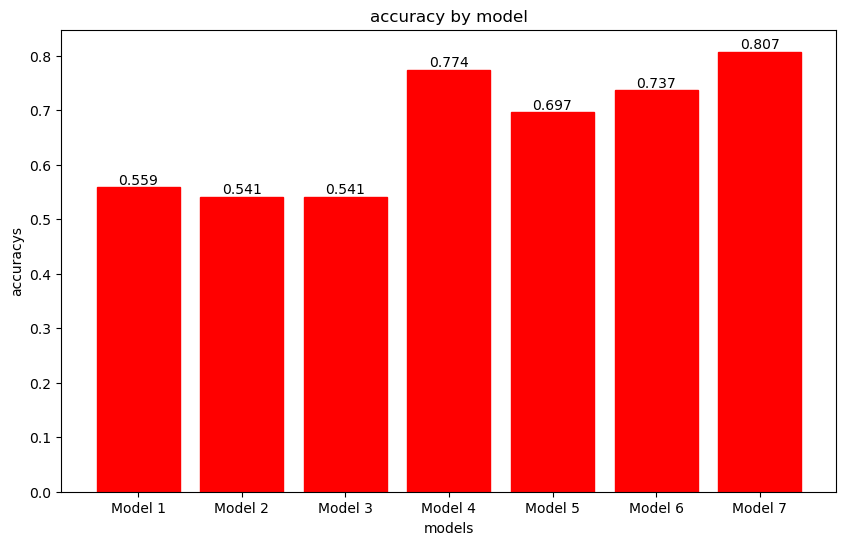

In [40]:
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
accuracys = [acc_test_1, acc_test_2, acc_test_3, acc_test_4, acc_test_5, acc_test_6, acc_test_7]

# Create an array of x-coordinates for the bars
x = np.arange(len(models))

plt.figure(figsize=[10,6])
# Plot the histogram
plt.bar(x, accuracys, color='red', edgecolor='red')

# Set the labels for each bar
plt.xticks(x, models)


for i, value in enumerate(accuracys):
    plt.text(x[i], value, str(round(value,3)), ha='center', va='bottom')

# Add labels and title
plt.xlabel('models')
plt.ylabel('accuracys')
plt.title('accuracy by model')

# Show the plot
plt.show()

## Discussion et commentaires

- Modèle 1 : RNN simple avec abandon, acc = 0,558 

Ce modèle, qui utilise un RNN de base avec abandon, a obtenu une précision de 0,558, ce qui suggère une faible performance. Cependant, il peut avoir du mal à capturer des modèles vocaux complexes. L'ajout de la régularisation dropout ne semble pas aider à prévenir l'overfitting. La simplicité du modèle pourrait être un facteur limitant, et l'exploration d'architectures ou de techniques de prétraitement plus avancées pourrait être bénéfique.


- Modèle 2 : RNN-LSTM gauche-droite classique, acc = 0,541 

Le modèle 2, qui utilise une LSTM traditionnelle de gauche à droite, a obtenu une précision de 0,541, ce qui indique qu'il est difficile de capturer le sentiment vocal. Le choix d'une seule couche LSTM traditionnelle n'était peut-être pas adapté à cette tâche, car elle ne pouvait pas capturer efficacement les modèles vocaux pertinents. L'expérimentation d'autres architectures ou techniques de prétraitement est nécessaire pour améliorer les performances du modèle.


- Modèle 3 : LSTM bi-directionnel avec return_sequences = False, acc = 0.541

Le modèle 3 a obtenu une précision de 0,541, similaire au modèle 2, ce qui suggère que la décision de retourner ou non les séquences peut ne pas avoir d'impact significatif sur les performances. D'autres expériences avec des LSTM bidirectionnelles et des configurations return_sequences pourraient permettre d'améliorer les performances.

- Modèle 4 : LSTM bi-directionnel + LSTM classique, acc = 0,774

Le modèle 4, une combinaison de LSTM bidirectionnelle et de LSTM classique, a excellé avec une précision de 0,774, démontrant dans ce cas l'efficacité de la capture du contexte dans les deux directions dans l'analyse des sentiments. Le modèle 4 semble prometteur et pourrait bénéficier d'une mise au point et d'une exploration plus poussées.

- Modèle 5 : Chaîne plus longue des LSTMs, acc = 0,696

Le modèle 5 a obtenu une précision de 0,696, ce qui, bien que raisonnable, n'est pas supérieur au modèle 4. Une chaîne plus longue de LSTMs pourrait ajouter de la complexité au modèle, mais ne conduirait pas nécessairement à de meilleures performances. La simplification de l'architecture tout en conservant les LSTM bidirectionnelles pourrait améliorer l'efficacité.

- Modèle 6 : LSTM bidirectionnelle + GlobalMaxPool1D + Dense, acc = 0,737

Le modèle 6 a obtenu une précision de 0,737, soit une amélioration modérée par rapport aux modèles 1 à 3. L'utilisation de GlobalMaxPool1D a pu aider à capturer des caractéristiques essentielles, mais des améliorations sont encore possibles. Une expérimentation plus approfondie avec différentes fonctions de mise en commun et d'activation pourrait permettre d'obtenir de meilleurs résultats.

- Modèle 7 : LSTM bi-directionnel + GlobalMaxPool1D + 2 couches denses, acc = 0,807

Le modèle 7 a atteint la précision la plus élevée (0,807), ce qui souligne l'efficacité de l'ajout de profondeur au modèle et de l'expérimentation des fonctions d'activation. L'inclusion de deux couches denses et le choix de fonctions d'activation, telles que tanh pour la sortie, ont contribué au succès du modèle. Les résultats soulignent l'impact de la profondeur du modèle et des fonctions d'activation, et il est recommandé de poursuivre l'exploration pour optimiser les performances.


$\bold{Remarque}$ : Tous les modèles ont montré un certain niveau de sur-apprentissage, ce qui est probablement dû à la taille limitée de l'ensemble de données. Des techniques de régularisation devraient être envisagées pour atténuer ce problème, et l'augmentation de la taille de l'ensemble de données serait bénéfique, ou la modification des paramètres d'apprentissage, mais nous avons préféré les conserver pour avoir une comparaison valable entre les modèles.

